# Deep Learning 2024 - project 1
Kinga Frańczak, 313335

Grzegorz Zakrzewski, 313555

In [1]:
# tensorflow==2.10.1
# pandas==1.5.3
# numpy==1.26.4
# seaborn==0.13.2
# matplotlib==3.8.3

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=0.9)
np.random.seed(0)
keras.utils.set_random_seed(0)

#### Loading data

In [2]:
REPETITIONS = 3  # number of repetitions of each experiment
EPOCHS = 30  # number of epochs usually used to train the models

directory_train = './archive/cinic-10_image_classification_challenge-dataset/train'
directory_test = './archive/cinic-10_image_classification_challenge-dataset/train'

In [3]:
DS_TRAIN, DS_VALID = keras.preprocessing.image_dataset_from_directory(
    directory_train,
    seed=0,
    image_size=(32, 32),
    validation_split=0.2,
    subset="both",
    batch_size=32
)

Found 90000 files belonging to 10 classes.
Using 72000 files for training.
Using 18000 files for validation.


#### Additional functions

In [ ]:
# function that fits the model and returns the results

def fit_model(
    model,
    name="",
    callbacks=[],
    optimizer="sgd",
    ds_train=DS_TRAIN,
    epochs=EPOCHS,
    repetitions=REPETITIONS,
):
    results = []
    for i in range(repetitions):
        model = keras.models.clone_model(model)
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        history = model.fit(ds_train, validation_data=DS_VALID, epochs=epochs, callbacks=callbacks)
        frame = pd.DataFrame(history.history)
        frame["Name"] = name
        frame["Repetition"] = i
        frame = frame.reset_index().rename(columns={"index": "Epoch"})
        results.append(frame)
    return pd.concat(results)

In [54]:
# function that returns the lowest loss and the highest accuracy averaged over repetitions

def summary(results):
    tmp = (
        results.groupby(["Name", "Repetition"])
        .agg({"loss": "min", "accuracy": "max", "val_loss": "min", "val_accuracy": "max"})
        .groupby("Name")
    )
    mean = tmp.mean().round(3).applymap(lambda x: f"{x:.3f}")
    std = tmp.std().round(3).applymap(lambda x: f" ({x:.3f})")
    summary = mean + std
    return summary

In [140]:
# function that plots accuracy measure on validation set over epochs

def epoch_plot_accuracy(results, name, filename):
    tmp = (
        results.groupby([ "Name", "Epoch"])
        .agg({"val_accuracy": "mean"})
        .reset_index()
        .rename(columns={"Name": name})
    )
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.lineplot(data=tmp, x="Epoch", y="val_accuracy", hue=name, ax=ax)
    ax.set_ylim(0.0, 0.7)
    ax.set_xlim(-1, 30)
    ax.set_ylabel("Accuracy (validation set)")
    ax.set_xticks(ticks=[4, 9, 14, 19, 24, 29], labels=[5, 10, 15, 20, 25, 30])
    sns.move_legend(ax, "lower right")
    plt.savefig(f"images/{filename}", bbox_inches="tight", dpi=300)
    plt.show()

### Experiment 0.1 - simple convolutional neural network - testing various architectures

In [ ]:
# Model I - one convolutional layer 

model1 = keras.models.Sequential()

model1.add(keras.Input(shape=(32, 32, 3)))

# Convolutional layers
model1.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Flatten())

# Dense layers
model1.add(keras.layers.Dense(32, activation='relu')) 
model1.add(keras.layers.Dense(10, activation='softmax')) 

results1 = fit_model(model1, name="1 conv layer")

In [ ]:
# Model II - two convolutional layers 

model2 = keras.models.Sequential()
model2.add(keras.Input(shape=(32, 32, 3)))
model2.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(32, activation='relu')) 
model2.add(keras.layers.Dense(10, activation='softmax')) 

results2 = fit_model(model2, name="2 conv layers")

In [ ]:
# Model III - three convolutional layers 

model3 = keras.models.Sequential()
model3.add(keras.Input(shape=(32, 32, 3)))
model3.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(32, activation='relu')) 
model3.add(keras.layers.Dense(10, activation='softmax'))

results3 = fit_model(model3, name="3 conv layers")

In [ ]:
experiment01_results = pd.concat([results1, results2, results3])
experiment01_results.to_csv("results/experiment01_results.csv", index=False)

In [126]:
experiment01_results = pd.read_csv("results/experiment01_results.csv")
summary(experiment01_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
1 conv layer,0.455 (0.031),0.837 (0.010),1.405 (0.024),0.506 (0.007)
2 conv layers,0.438 (0.047),0.842 (0.018),1.328 (0.027),0.538 (0.004)
3 conv layers,1.017 (0.007),0.636 (0.003),1.227 (0.006),0.565 (0.004)


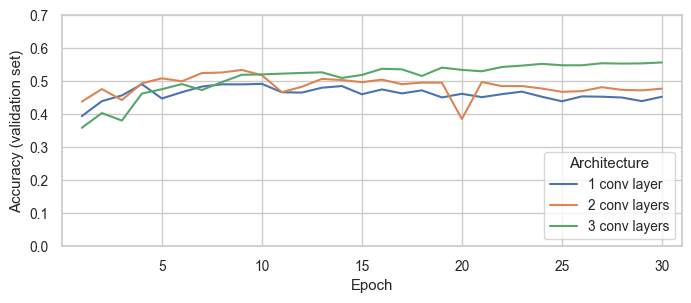

In [141]:
epoch_plot_accuracy(experiment01_results, "Architecture", "experiment01.png")

## #1 - Testing hyper-parameters

## #1a - training

In [ ]:
# baseline model -> the best model from Experiment 0.1
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu')) 
model.add(keras.layers.Dense(10, activation='softmax'))

### Experiment 1.1. - optimizers

In [ ]:
OPTIMIZERS = ["sgd", "rmsprop", "adam", "adadelta"]
experiment11_results = []

for optimizer in OPTIMIZERS:
    results = fit_model(model, name=optimizer, optimizer=optimizer)
    experiment11_results.append(results)

experiment11_results = pd.concat(experiment11_results)
experiment11_results.to_csv("results/experiment11_results.csv", index=False)

In [56]:
experiment11_results = pd.read_csv("results/experiment11_results.csv")
summary(experiment11_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
adadelta,1.939 (0.004),0.289 (0.006),1.963 (0.004),0.291 (0.005)
adam,0.904 (0.000),0.674 (0.000),1.214 (0.004),0.572 (0.003)
rmsprop,0.986 (0.046),0.646 (0.016),1.217 (0.016),0.571 (0.004)
sgd,1.025 (0.014),0.634 (0.006),1.226 (0.018),0.567 (0.006)


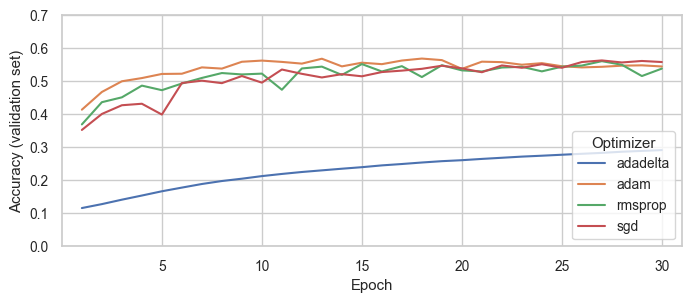

In [142]:
epoch_plot_accuracy(experiment11_results, "Optimizer", "experiment11.png")

### Experiment 1.2. - learning rate

In [ ]:
# the best optimazer from Experiment 1.1 is: 
    # Adam optimizer

experiment12_results = []

for learning_rate in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    results = fit_model(model, name=learning_rate, optimizer=optimizer)
    experiment12_results.append(results)

experiment12_results = pd.concat(experiment12_results)
experiment12_results.to_csv("results/experiment12_results.csv", index=False)

In [112]:
experiment12_results = pd.read_csv("results/experiment12_results.csv").astype({"Name": str})
summary(experiment12_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
0.0001,1.051 (0.018),0.625 (0.007),1.253 (0.011),0.557 (0.005)
0.0005,0.952 (0.043),0.658 (0.015),1.215 (0.005),0.574 (0.001)
0.001,0.970 (0.053),0.652 (0.017),1.221 (0.011),0.568 (0.001)
0.005,1.135 (0.027),0.592 (0.011),1.300 (0.029),0.542 (0.004)
0.01,1.960 (0.595),0.247 (0.253),2.088 (0.668),0.242 (0.245)


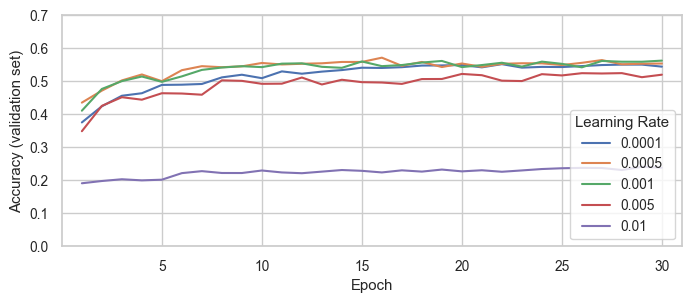

In [143]:
epoch_plot_accuracy(experiment12_results, "Learning Rate", "experiment12.png")

## #1b - regularization

In [ ]:
# the best optimizer and with the finest value of learning rate parameter from Experiments 1.1 and 1.2
optimizer = keras.optimizers.Adam(learning_rate=0.001)

### Experiment 1.3. - dropout rate

In [ ]:
experiment13_results = []

for dropout_rate in [0.2, 0.4, 0.6]:

    # the best model from Experiment 0.1
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(32, 32, 3)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())

    # dropout
    model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(32, activation='relu')) 
    model.add(keras.layers.Dense(10, activation='softmax'))

    results = fit_model(model, name=dropout_rate, optimizer=optimizer)
    experiment13_results.append(results)

experiment13_results = pd.concat(experiment13_results)
experiment13_results.to_csv("results/experiment13_results.csv", index=False)

In [115]:
experiment13_results = pd.read_csv("results/experiment13_results.csv").astype({"Name": str})
summary(experiment13_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
0.2,1.058 (0.052),0.619 (0.020),1.144 (0.022),0.589 (0.008)
0.4,1.121 (0.019),0.597 (0.007),1.149 (0.028),0.585 (0.010)
0.6,1.192 (0.018),0.572 (0.008),1.159 (0.013),0.582 (0.009)


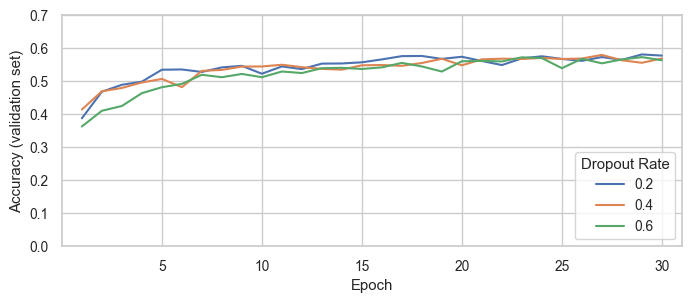

In [144]:
epoch_plot_accuracy(experiment13_results, "Dropout Rate", "experiment13.png")

### Experiment 1.4. - early stopping

In [ ]:
# the model with best architecture, optimizer, learning rate and dropout from previous experiments
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu')) 
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
experiment14_results = []

for patience in [2, 4, 6]:
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)

    results = fit_model(model, name=patience, optimizer=optimizer, callbacks=[callback], epochs=40)
    experiment14_results.append(results)

experiment14_results = pd.concat(experiment14_results)
experiment14_results.to_csv("results/experiment14_results.csv", index=False)

In [120]:
experiment14_results = pd.read_csv("results/experiment14_results.csv").astype({"Name": str})
summary(experiment14_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
2,1.230 (0.098),0.556 (0.037),1.282 (0.093),0.536 (0.040)
4,1.153 (0.008),0.585 (0.002),1.214 (0.020),0.563 (0.008)
6,1.121 (0.011),0.596 (0.005),1.192 (0.032),0.572 (0.012)


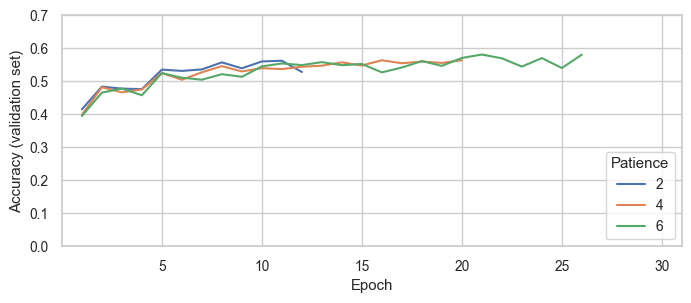

In [145]:
epoch_plot_accuracy(experiment14_results, "Patience", "experiment14.png")

## #2 - Testing augmentation techniques

In [ ]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))
model.add(keras.layers.RandomFlip())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu')) 
model.add(keras.layers.Dense(10, activation='softmax'))
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

### Experiment 2.1 - image flips

In [ ]:
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical")
])
ds_augmented = DS_TRAIN.shuffle(2250).take(750).map(lambda x, y: (flip_augmentation(x, training=True), y), tf.data.AUTOTUNE)
ds_train = DS_TRAIN.concatenate(ds_augmented)

results = fit_model(model, name="random flip", ds_train=ds_train, optimizer=optimizer, callbacks=[callback])
results.to_csv("results/experiment21_results.csv", index=False)

### Experiment 2.2 - image rotations

In [ ]:
rotation_augmentation = tf.keras.Sequential([
    keras.layers.RandomRotation(factor=0.5)
])
ds_augmented = DS_TRAIN.shuffle(2250).take(750).map(lambda x, y: (rotation_augmentation(x, training=True), y), tf.data.AUTOTUNE)
ds_train = DS_TRAIN.concatenate(ds_augmented)

results = fit_model(model, name="random rotation", ds_train=ds_train, optimizer=optimizer, callbacks=[callback])
results.to_csv("results/experiment22_results.csv", index=False)

### Experiment 2.3 - image shifts

In [ ]:
# keras.layers.RandomTranslation
translation_augmentation = tf.keras.Sequential([
    keras.layers.RandomTranslation(height_factor=0.5, width_factor=0.5)
])
ds_augmented = DS_TRAIN.shuffle(2250).take(750).map(lambda x, y: (translation_augmentation(x, training=True), y), tf.data.AUTOTUNE)
ds_train = DS_TRAIN.concatenate(ds_augmented)

results = fit_model(model, name="random translation", ds_train=ds_train, optimizer=optimizer, callbacks=[callback])
results.to_csv("results/experiment23_results.csv", index=False)

### Experiment 2.4 - MixUp augmentation (more advanced technique)

In [238]:
# modified example from: https://keras.io/examples/vision/mixup/

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def mix_up(ds_one, ds_two, alpha=0.2):
    images_one = ds_one[0]
    labels_one = ds_one[1]
    images_two = ds_two[0]
    labels_two = ds_two[1]

    l = sample_beta_distribution(32, alpha, alpha)
    x_l = tf.reshape(l, (32, 1, 1, 1))
    y_l = tf.reshape(l, (32,))

    images = tf.cast(images_one, tf.float32) * x_l + tf.cast(images_two, tf.float32) * (1. - x_l)
    labels = tf.cast(tf.cast(labels_one, tf.float32) * y_l + tf.cast(labels_two, tf.float32) * (1. - y_l), tf.int32)
    return (images, labels)

In [ ]:
ds_sample1 = DS_TRAIN.shuffle(2250).take(750)
ds_sample2 = DS_TRAIN.shuffle(2250).take(750)
ds_sample = tf.data.Dataset.zip((ds_sample1, ds_sample2))

ds_augmented = ds_sample.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=tf.data.AUTOTUNE,
)

results = fit_model(model, name=f"mix up", ds_train=ds_train, optimizer=optimizer, callbacks=[callback])
results.to_csv("results/experiment24_results.csv", index=False)

#### Experiment 2. - results

In [146]:
experiment2_results = pd.concat([
    pd.read_csv("results/experiment21_results.csv"),
    pd.read_csv("results/experiment22_results.csv"),
    pd.read_csv("results/experiment23_results.csv"),
    pd.read_csv("results/experiment24_results.csv"),
])
summary(experiment2_results)

,loss,accuracy,val_loss,val_accuracy
Name,,,,
mix up,1.285 (0.047),0.535 (0.017),1.339 (0.056),0.506 (0.026)
random flip,1.142 (0.077),0.588 (0.030),1.459 (0.458),0.481 (0.160)
random rotation,1.296 (0.066),0.531 (0.026),1.496 (0.235),0.451 (0.093)
random translation,1.305 (0.052),0.526 (0.020),1.504 (0.266),0.448 (0.100)


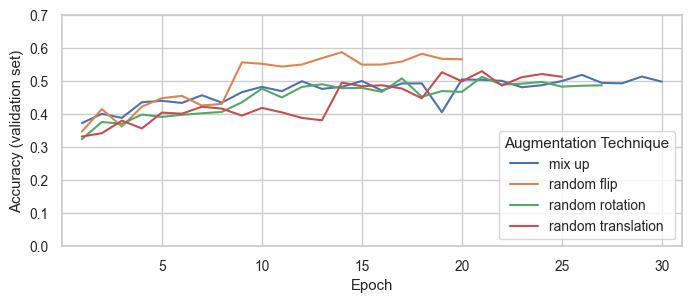

In [147]:
epoch_plot_accuracy(experiment2_results, "Augmentation Technique", "experiment2.png")

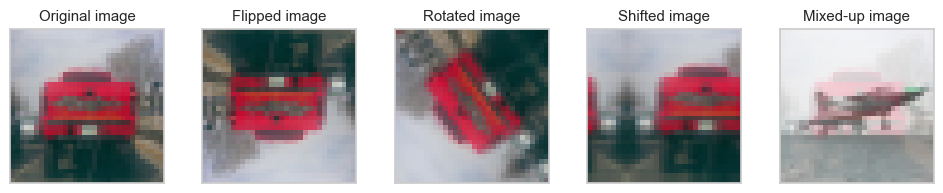

In [299]:
# augmentation techniques example
images, labels = next(iter(DS_TRAIN))
image = images[0]
flipped_image = flip_augmentation(image).numpy().astype(int)
rotated_image = rotation_augmentation(image).numpy().astype(int)
shifted_image = translation_augmentation(image).numpy().astype(int)

images2, labels2 = next(iter(DS_TRAIN))
mixed_up_images = mix_up((images, labels), (images2, labels2), alpha=0.2)
mixed_up_image = next(iter(mixed_up_images))[0].numpy().astype(int)

image = image.numpy().astype(int)

fig, axs = plt.subplots(1, 5, figsize=(12, 2))
axs[0].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].imshow(flipped_image, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(rotated_image, cmap='gray', vmin=0, vmax=255)
axs[3].imshow(shifted_image, cmap='gray', vmin=0, vmax=255)
axs[4].imshow(mixed_up_image, cmap='gray', vmin=0, vmax=255)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
axs[0].set_title("Original image")
axs[1].set_title("Flipped image")
axs[2].set_title("Rotated image")
axs[3].set_title("Shifted image")
axs[4].set_title("Mixed-up image")
plt.savefig(f"images/augmentation_techniques_example", bbox_inches="tight", dpi=300)
plt.show()

## #3 - Testing pre-trained models 